In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from pathlib import Path
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [2]:
path = Path('../input/linking-writing-processes-to-writing-quality')
path_keystroke_measures = Path('../input/keystroke-measures/train_logs.pkl')

In [3]:
os.listdir(path)

['sample_submission.csv',
 'test_logs.csv',
 'train_scores.csv',
 'train_logs.csv']

In [4]:
# train_logs will be imported from another file, with added keystroke features
test_logs = pd.read_csv(path/'test_logs.csv')
sample_submission = pd.read_csv(path/'sample_submission.csv')
train_scores = pd.read_csv(path/'train_scores.csv')

In [5]:
test_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [6]:
sample_submission

,id,score
0,0000aaaa,1.0
1,2222bbbb,2.0
2,4444cccc,3.0


In [7]:
DEBUG = False

with open(path_keystroke_measures, 'rb') as file:
    train_logs = pd.read_pickle(file)
    
if DEBUG:
    num_essays = 100
    train_logs = train_logs[train_logs.id.isin(train_logs.id.unique()[:num_essays])]
    print(f"Debug mode activated. Utilizing {num_essays} essays.")
else:
    print(f"Debug mode has been deactivated. The whole dataset will be utilized ({train_logs.id.nunique()} essays).")

Debug mode has been deactivated. The whole dataset will be utilized (2471 essays).


In [8]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,total_time_mins,chars_product,chars_per_min_product,chars_process,chars_per_min_process,words_per_min_product,words_per_min_process,sentences_per_min_process,sentences_per_min_product,paragraphs_per_min_process,num_pauses,pauses_per_min,pause_time_proportion_perc,mean_pause_length,mean_pause_length_btw_paragraphs,mean_pause_length_btw_sentences,mean_pause_length_btw_words,mean_pause_length_w_in_words,deletions,deletions_per_min,mean_length_deletions,distant_deletions,deletions_proportion_perc,imm_deletions,distant_deletion_ratio,product_process_ratio,p_bursts,r_bursts,p_bursts_per_min,r_bursts_per_min,mean_p_bursts_chars,mean_r_bursts_chars,p_bursts_proportion_perc,r_bursts_proportion_perc,std_chars_interval
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,30.0,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,30.0,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,30.0,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,30.0,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,30.0,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2


Average number of logs per essay = 3401.8


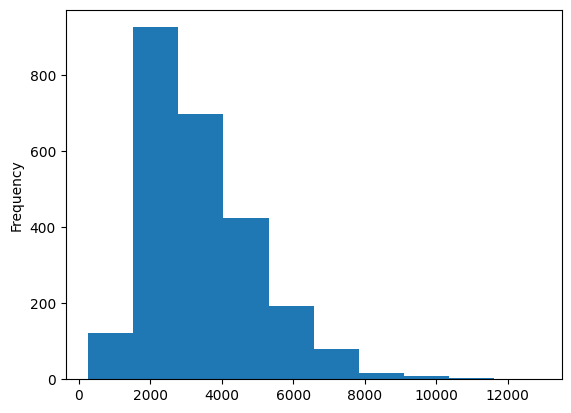

In [9]:
# logs per essay and distribution
print('Average number of logs per essay =', np.round(len(train_logs)/len(train_logs.id.value_counts()),1))
train_logs.id.value_counts().plot(kind='hist');

In [10]:
# Registered events
train_logs.down_event.unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [11]:
# control key events
train_logs['num_control_key'] = train_logs.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())

In [12]:
# Hypothesis to explore:
# - Best writers have more clarity of thought -> less corrections - keystroke features
# - Best writers spend a larger share of time reviewing - keystroke features
# - Best writers spend a larger share of time thinking, in pause - keystroke features
# - Best writers spend a larger share of time in bursts (better short-term memory) - keystroke features
# - Volume-related events: tendency to get distracted - tiny sample 
# - Volume-related events: focused if shutting down noise  - tiny sample
# - Better handling of keyboard shortcuts could be associated with higher competence - num_control_key feature
# - Those with more periods of inactivity have lower performance - keystroke features

Possible values for essay score are: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]


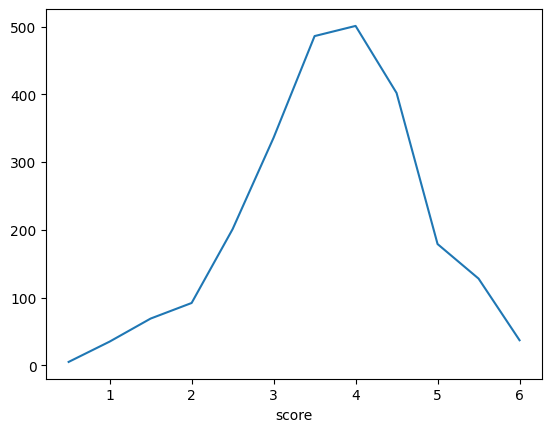

In [13]:
print('Possible values for essay score are:',sorted(train_scores.score.unique()))
train_scores.score.value_counts().sort_index(ascending=False).plot();

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scores.score = scaler.fit_transform(train_scores[['score']])

train_scores.score = pd.Categorical(train_scores.score, sorted(train_scores.score.unique()), ordered=True)
train_scores.score.unique()

[0.545455, 1.000000, 0.272727, 0.636364, 0.727273, ..., 0.454545, 0.181818, 0.909091, 0.090909, 0.000000]
Length: 12
Categories (12, float64): [0.000000 < 0.090909 < 0.181818 < 0.272727 ... 0.727273 < 0.818182 < 0.909091 < 1.000000]

In [15]:
redundant_vars = ['num_pauses', 'chars_process', 'chars_product']
train_logs.drop(redundant_vars, axis=1, inplace=True)

In [16]:
original_cols_ex_id = ['event_id', 'down_time', 'up_time', 'action_time', 'activity',
                       'down_event', 'up_event', 'text_change', 'cursor_position', 'word_count']

simplified_train_logs = train_logs.drop(original_cols_ex_id, axis=1)

In [17]:
np.round(simplified_train_logs.duplicated().mean(), 4)

0.9997

In [18]:
simplified_train_logs.drop_duplicates(inplace=True)
simplified_train_logs.reset_index(drop=True, inplace=True)
simplified_train_logs

,id,total_time_mins,chars_per_min_product,chars_per_min_process,words_per_min_product,words_per_min_process,sentences_per_min_process,sentences_per_min_product,paragraphs_per_min_process,pauses_per_min,pause_time_proportion_perc,mean_pause_length,mean_pause_length_btw_paragraphs,mean_pause_length_btw_sentences,mean_pause_length_btw_words,mean_pause_length_w_in_words,deletions,deletions_per_min,mean_length_deletions,distant_deletions,deletions_proportion_perc,imm_deletions,distant_deletion_ratio,product_process_ratio,p_bursts,r_bursts,p_bursts_per_min,r_bursts_per_min,mean_p_bursts_chars,mean_r_bursts_chars,p_bursts_proportion_perc,r_bursts_proportion_perc,std_chars_interval,num_control_key
0,001519c8,30.0,50.9,67.2,8.5,11.6,0.7,21.8,0.1,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2,0
1,0022f953,29.8,56.2,65.1,10.7,12.4,0.6,17.9,0.2,2.7,65.8,14521.8,NaN,3197.7,1207.0,784.3,82.0,2.8,3.2,8.0,0.0,74.0,0.1,0.9,8.0,20.0,0.3,0.7,34.9,37.2,3.1,8.3,8.3,0
2,0042269b,29.5,87.7,119.4,13.7,18.6,0.7,20.9,0.6,2.6,62.8,14430.7,4804.0,3315.3,1637.2,492.0,97.0,3.3,4.5,5.0,0.0,92.0,0.1,0.7,17.0,47.0,0.6,1.6,39.9,39.4,4.1,12.1,3.7,0
3,0059420b,23.4,49.3,56.3,8.8,10.4,0.6,13.0,0.1,3.7,54.7,8828.4,61128.7,14315.4,2824.9,1199.7,66.0,2.8,2.3,1.0,0.0,65.0,0.0,0.9,4.0,3.0,0.2,0.1,27.5,28.7,3.4,2.1,2.8,4
4,0075873a,27.7,51.4,70.1,9.1,12.2,0.9,24.7,0.4,3.2,62.9,11880.3,37640.0,12462.1,2293.4,1212.0,58.0,2.1,8.9,8.0,0.0,50.0,0.1,0.7,16.0,8.0,0.6,0.3,47.2,32.2,9.1,3.0,3.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,29.9,54.6,120.1,9.1,20.7,1.5,43.4,0.2,1.4,53.9,23604.8,19852.0,1804.6,475.0,593.1,84.0,2.8,11.4,2.0,0.0,82.0,0.0,0.5,12.0,45.0,0.4,1.5,52.0,45.0,6.3,17.9,7.0,0
2467,ffbef7e5,30.0,77.8,79.9,14.6,15.0,1.0,30.9,0.4,3.0,53.9,10770.9,22906.5,8939.7,1625.9,1654.3,12.0,0.4,5.0,1.0,0.0,11.0,0.1,1.0,20.0,12.0,0.7,0.4,36.8,41.5,11.6,8.9,3.3,0
2468,ffccd6fd,32.7,84.4,87.1,6.1,6.5,0.2,5.0,0.4,2.7,58.1,13101.2,NaN,NaN,4482.2,1907.9,42.0,1.3,2.1,4.0,0.0,38.0,0.1,1.0,7.0,5.0,0.2,0.2,34.6,31.8,4.6,3.6,13.1,0
2469,ffec5b38,25.1,101.7,115.3,16.5,18.8,1.3,31.8,0.2,2.5,49.0,11720.1,49251.3,6981.3,1137.7,745.1,92.0,3.7,3.0,3.0,0.0,89.0,0.0,0.9,15.0,27.0,0.6,1.1,41.3,37.6,8.7,13.7,2.9,0


In [19]:
simplified_train_logs.drop('id', axis=1, inplace=True)
simplified_train_logs.head()

,total_time_mins,chars_per_min_product,chars_per_min_process,words_per_min_product,words_per_min_process,sentences_per_min_process,sentences_per_min_product,paragraphs_per_min_process,pauses_per_min,pause_time_proportion_perc,mean_pause_length,mean_pause_length_btw_paragraphs,mean_pause_length_btw_sentences,mean_pause_length_btw_words,mean_pause_length_w_in_words,deletions,deletions_per_min,mean_length_deletions,distant_deletions,deletions_proportion_perc,imm_deletions,distant_deletion_ratio,product_process_ratio,p_bursts,r_bursts,p_bursts_per_min,r_bursts_per_min,mean_p_bursts_chars,mean_r_bursts_chars,p_bursts_proportion_perc,r_bursts_proportion_perc,std_chars_interval,num_control_key
0,30.0,50.9,67.2,8.5,11.6,0.7,21.8,0.1,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2,0
1,29.8,56.2,65.1,10.7,12.4,0.6,17.9,0.2,2.7,65.8,14521.8,NaN,3197.7,1207.0,784.3,82.0,2.8,3.2,8.0,0.0,74.0,0.1,0.9,8.0,20.0,0.3,0.7,34.9,37.2,3.1,8.3,8.3,0
2,29.5,87.7,119.4,13.7,18.6,0.7,20.9,0.6,2.6,62.8,14430.7,4804.0,3315.3,1637.2,492.0,97.0,3.3,4.5,5.0,0.0,92.0,0.1,0.7,17.0,47.0,0.6,1.6,39.9,39.4,4.1,12.1,3.7,0
3,23.4,49.3,56.3,8.8,10.4,0.6,13.0,0.1,3.7,54.7,8828.4,61128.7,14315.4,2824.9,1199.7,66.0,2.8,2.3,1.0,0.0,65.0,0.0,0.9,4.0,3.0,0.2,0.1,27.5,28.7,3.4,2.1,2.8,4
4,27.7,51.4,70.1,9.1,12.2,0.9,24.7,0.4,3.2,62.9,11880.3,37640.0,12462.1,2293.4,1212.0,58.0,2.1,8.9,8.0,0.0,50.0,0.1,0.7,16.0,8.0,0.6,0.3,47.2,32.2,9.1,3.0,3.8,0


In [20]:
simplified_train_logs = simplified_train_logs.merge(train_scores.drop('id', axis=1), left_index=True, right_index=True)

In [21]:
len(simplified_train_logs.columns)

34

In [22]:
simplified_train_logs.isna().sum().sort_values(ascending=False)[:6]

mean_pause_length_btw_paragraphs    614
mean_r_bursts_chars                  30
mean_pause_length_btw_sentences      20
mean_p_bursts_chars                   9
mean_length_deletions                 1
distant_deletion_ratio                1
dtype: int64

In [23]:
simplified_train_logs.columns

Index(['total_time_mins', 'chars_per_min_product', 'chars_per_min_process',
       'words_per_min_product', 'words_per_min_process',
       'sentences_per_min_process', 'sentences_per_min_product',
       'paragraphs_per_min_process', 'pauses_per_min',
       'pause_time_proportion_perc', 'mean_pause_length',
       'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
       'mean_pause_length_btw_words', 'mean_pause_length_w_in_words',
       'deletions', 'deletions_per_min', 'mean_length_deletions',
       'distant_deletions', 'deletions_proportion_perc', 'imm_deletions',
       'distant_deletion_ratio', 'product_process_ratio', 'p_bursts',
       'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
       'mean_p_bursts_chars', 'mean_r_bursts_chars',
       'p_bursts_proportion_perc', 'r_bursts_proportion_perc',
       'std_chars_interval', 'num_control_key', 'score'],
      dtype='object')

In [24]:
# feature clusters
production_cluster = ['chars_per_min_product', 'chars_per_min_process', 'words_per_min_product', 
                      'words_per_min_process', 'sentences_per_min_process', 'sentences_per_min_product',
                      'paragraphs_per_min_process']
pause_cluster = ['pauses_per_min', 'pause_time_proportion_perc', 'mean_pause_length', 
                 'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
                 'mean_pause_length_btw_words', 'mean_pause_length_w_in_words']
deletions_cluster = ['deletions', 'deletions_per_min', 'mean_length_deletions', 'distant_deletions', 
                     'deletions_proportion_perc', 'imm_deletions', 'distant_deletion_ratio']
bursts_cluster = ['p_bursts', 'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
                  'mean_p_bursts_chars', 'mean_r_bursts_chars', 'p_bursts_proportion_perc', 
                  'r_bursts_proportion_perc']

feature_clusters = [production_cluster, pause_cluster, deletions_cluster, bursts_cluster]
feature_clusters_str = ['production cluster', 'pause cluster', 'deletions cluster', 'bursts cluster']

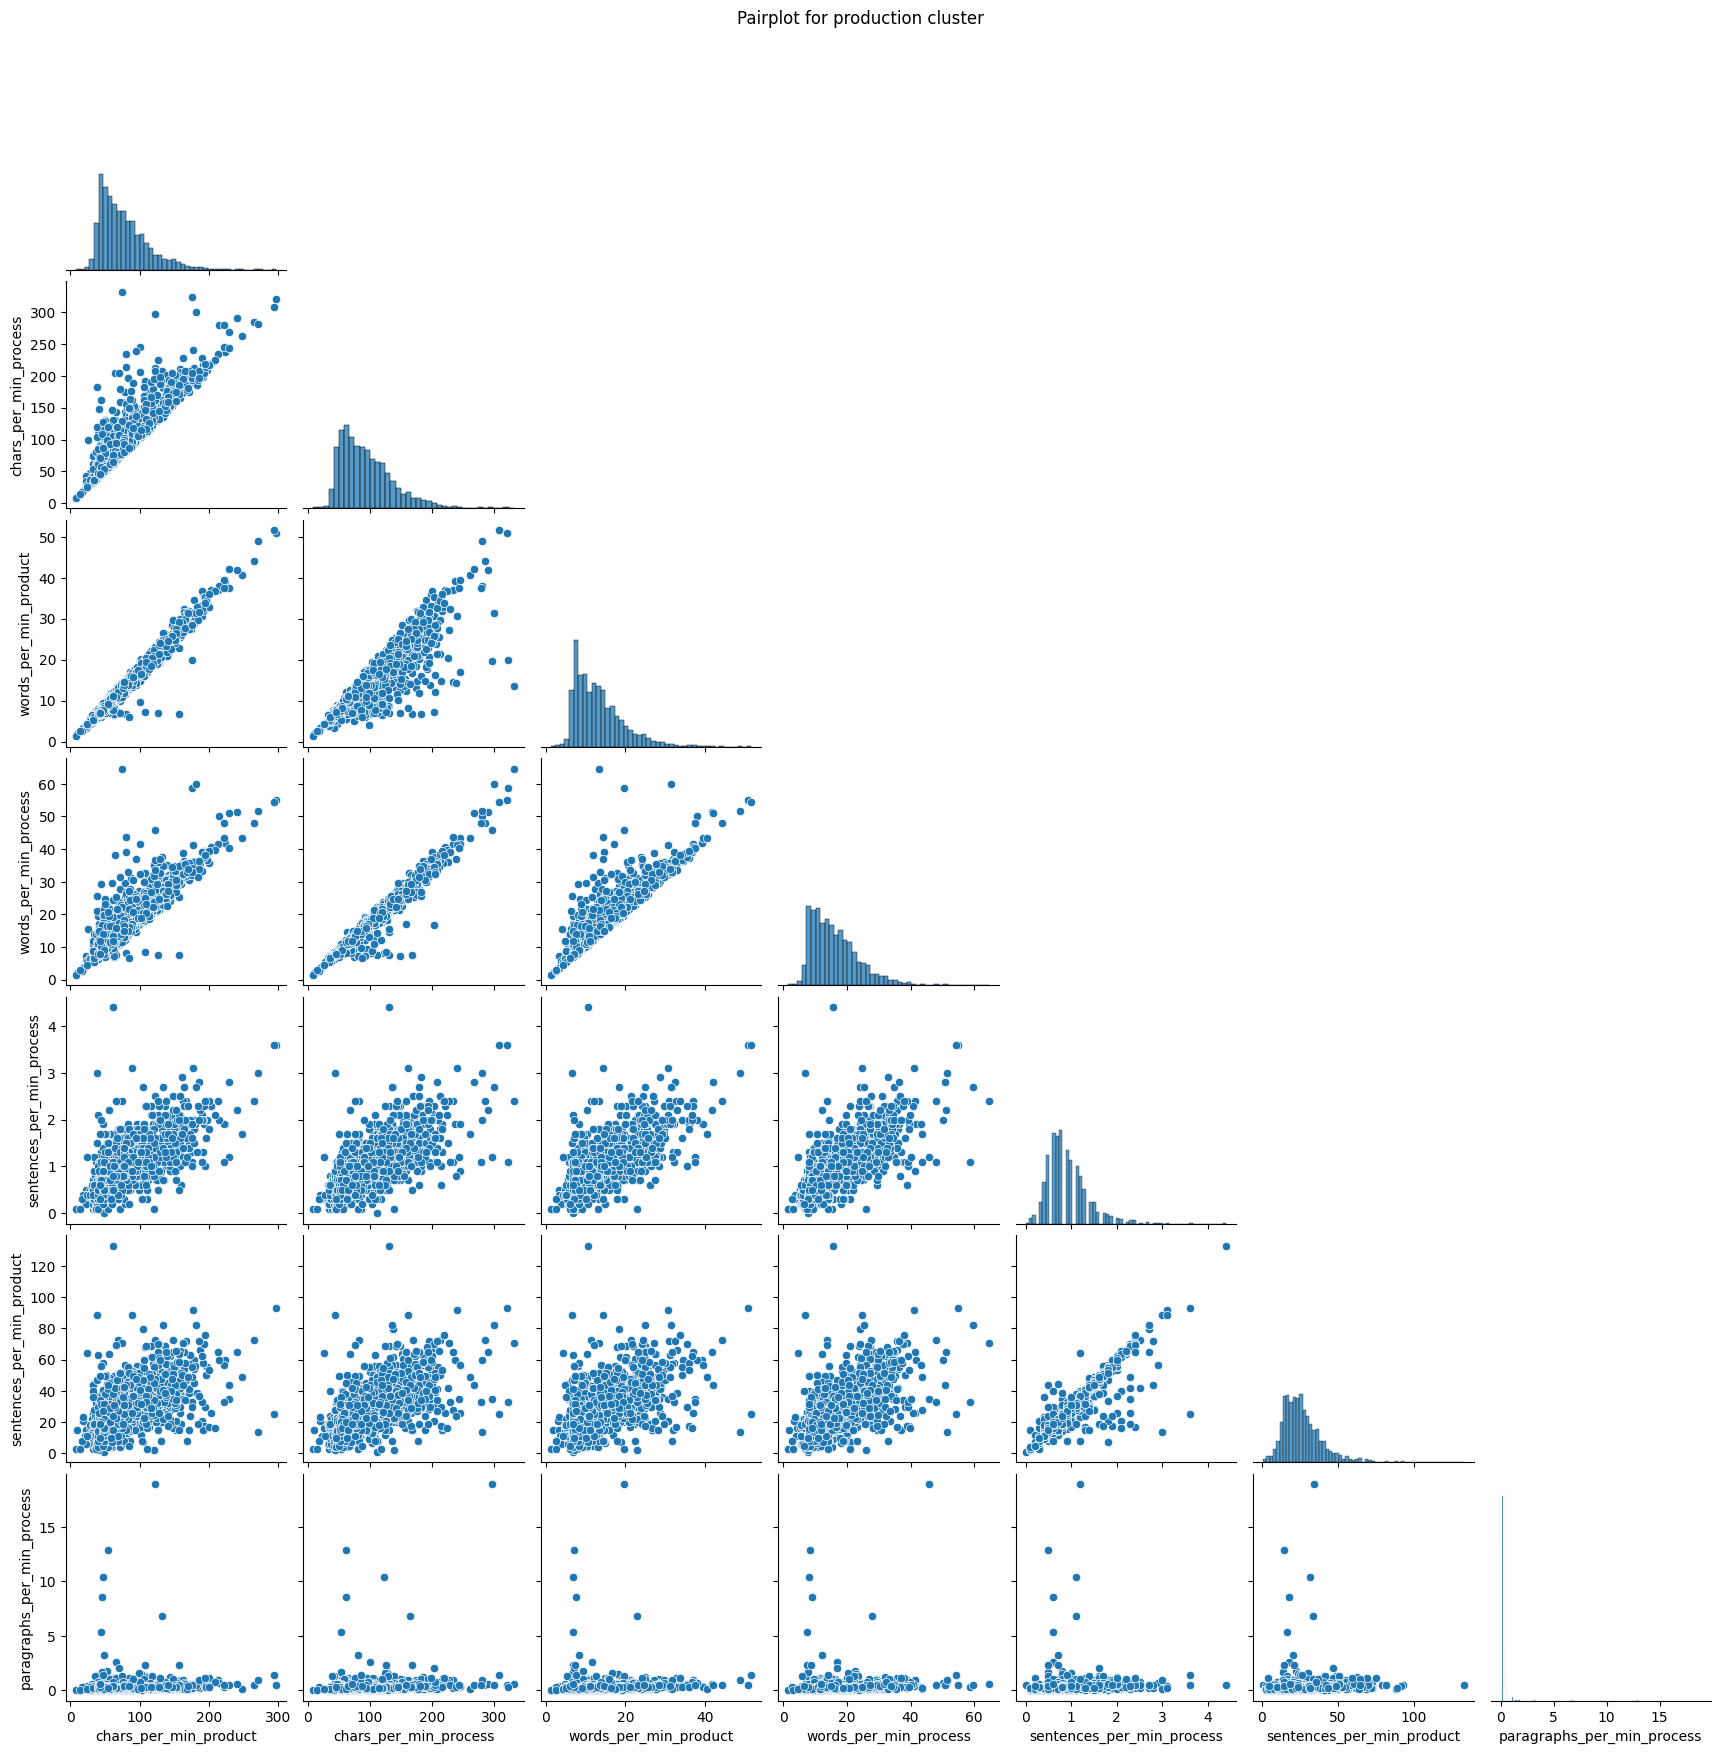

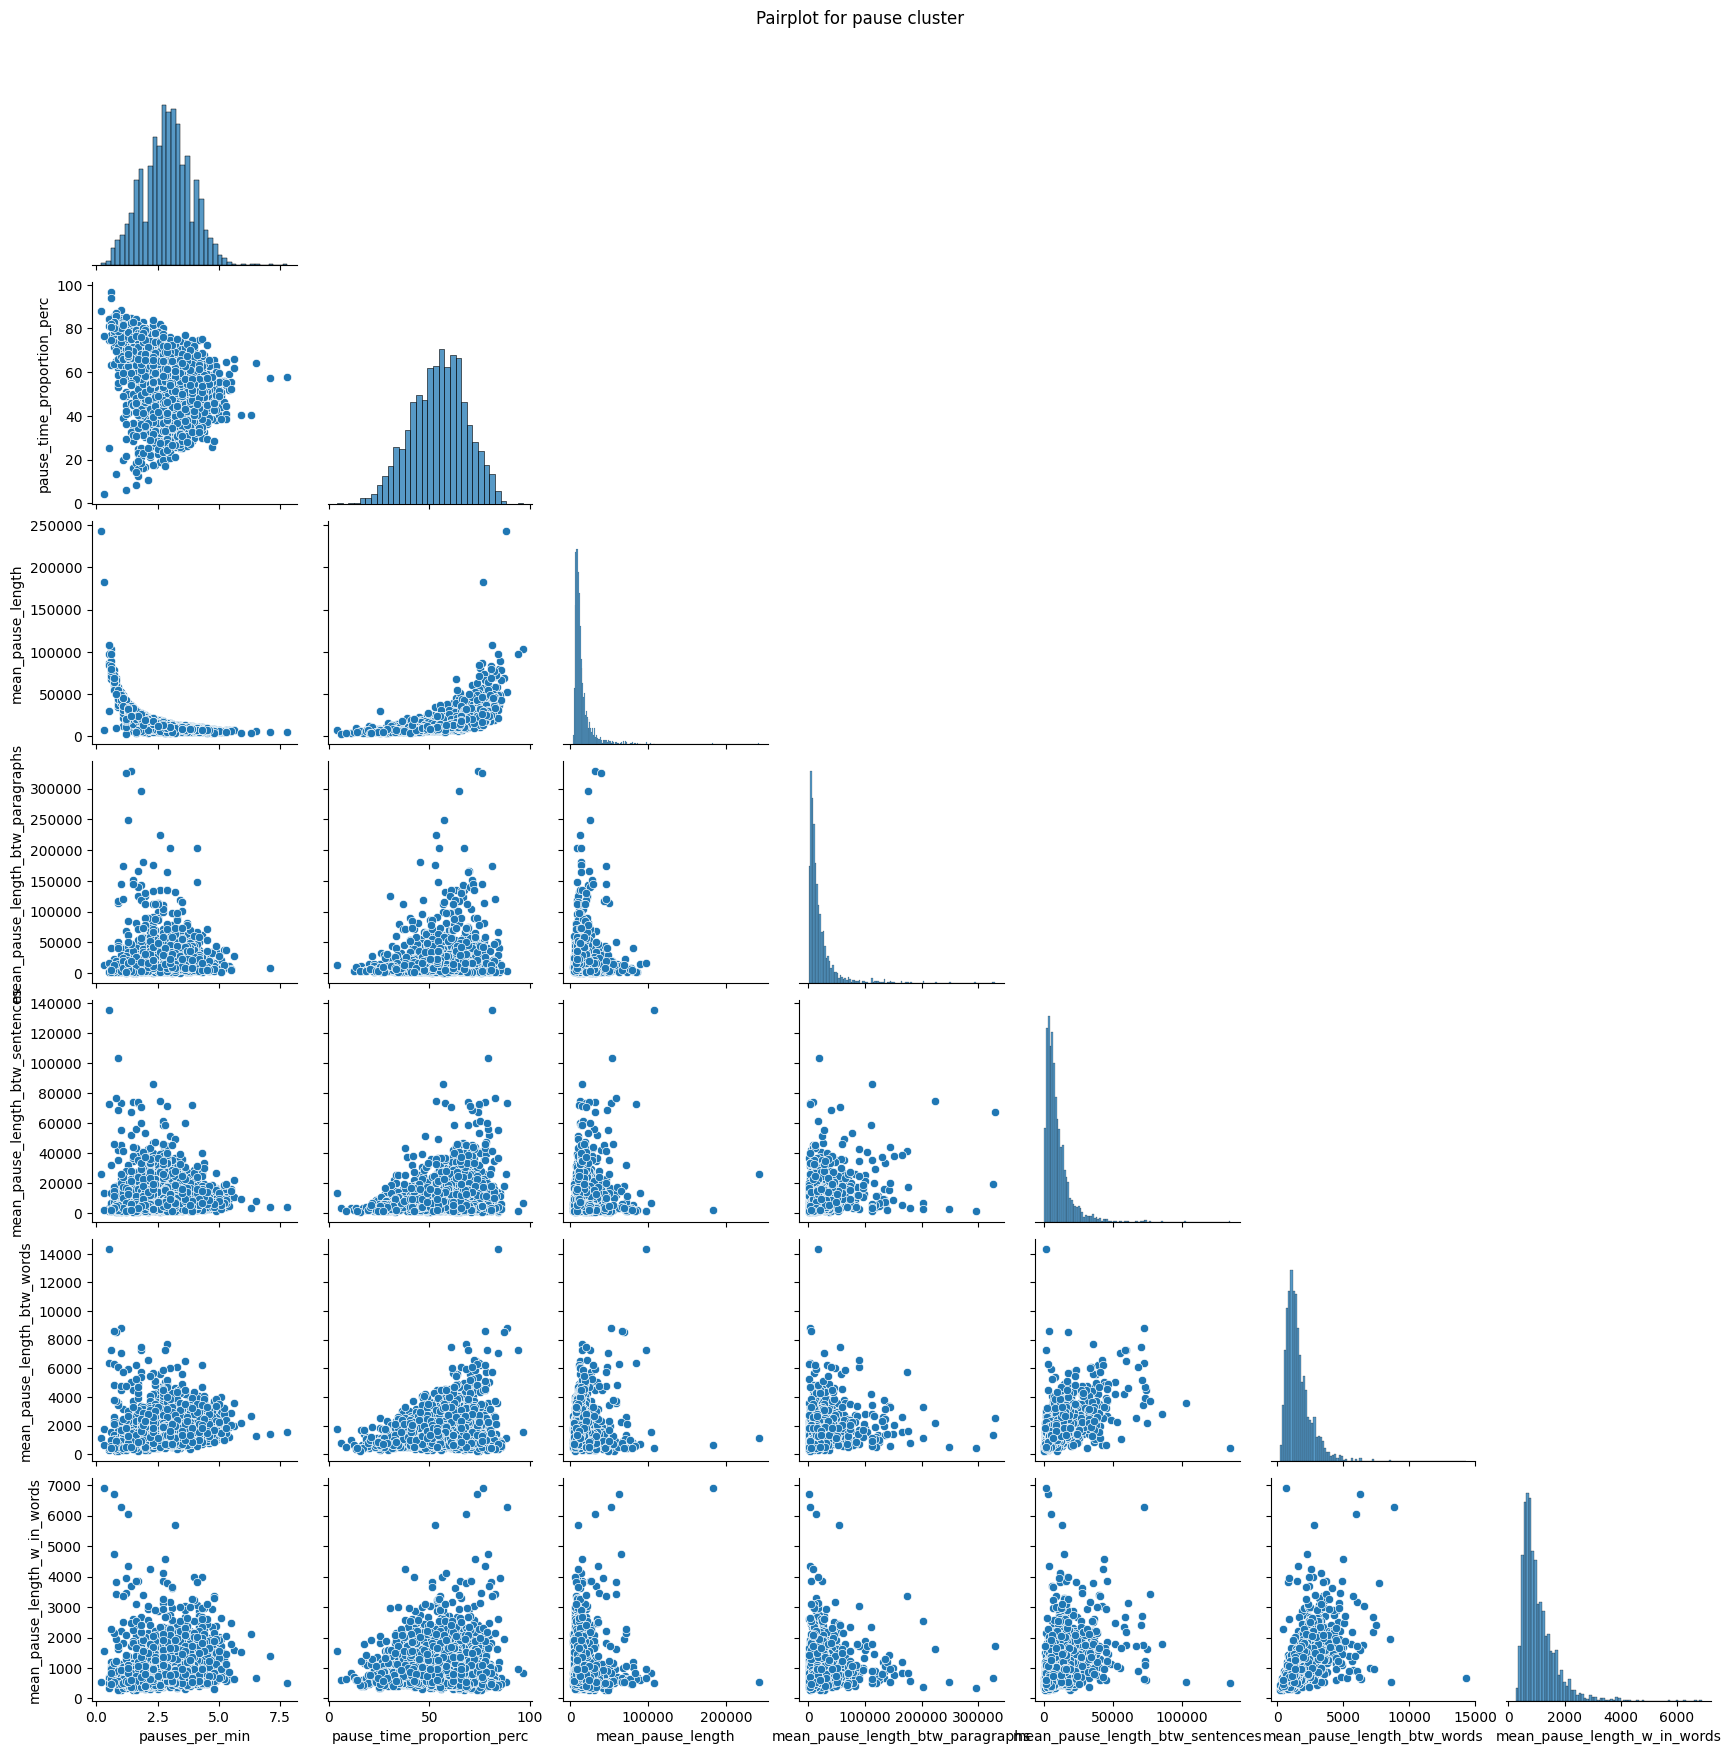

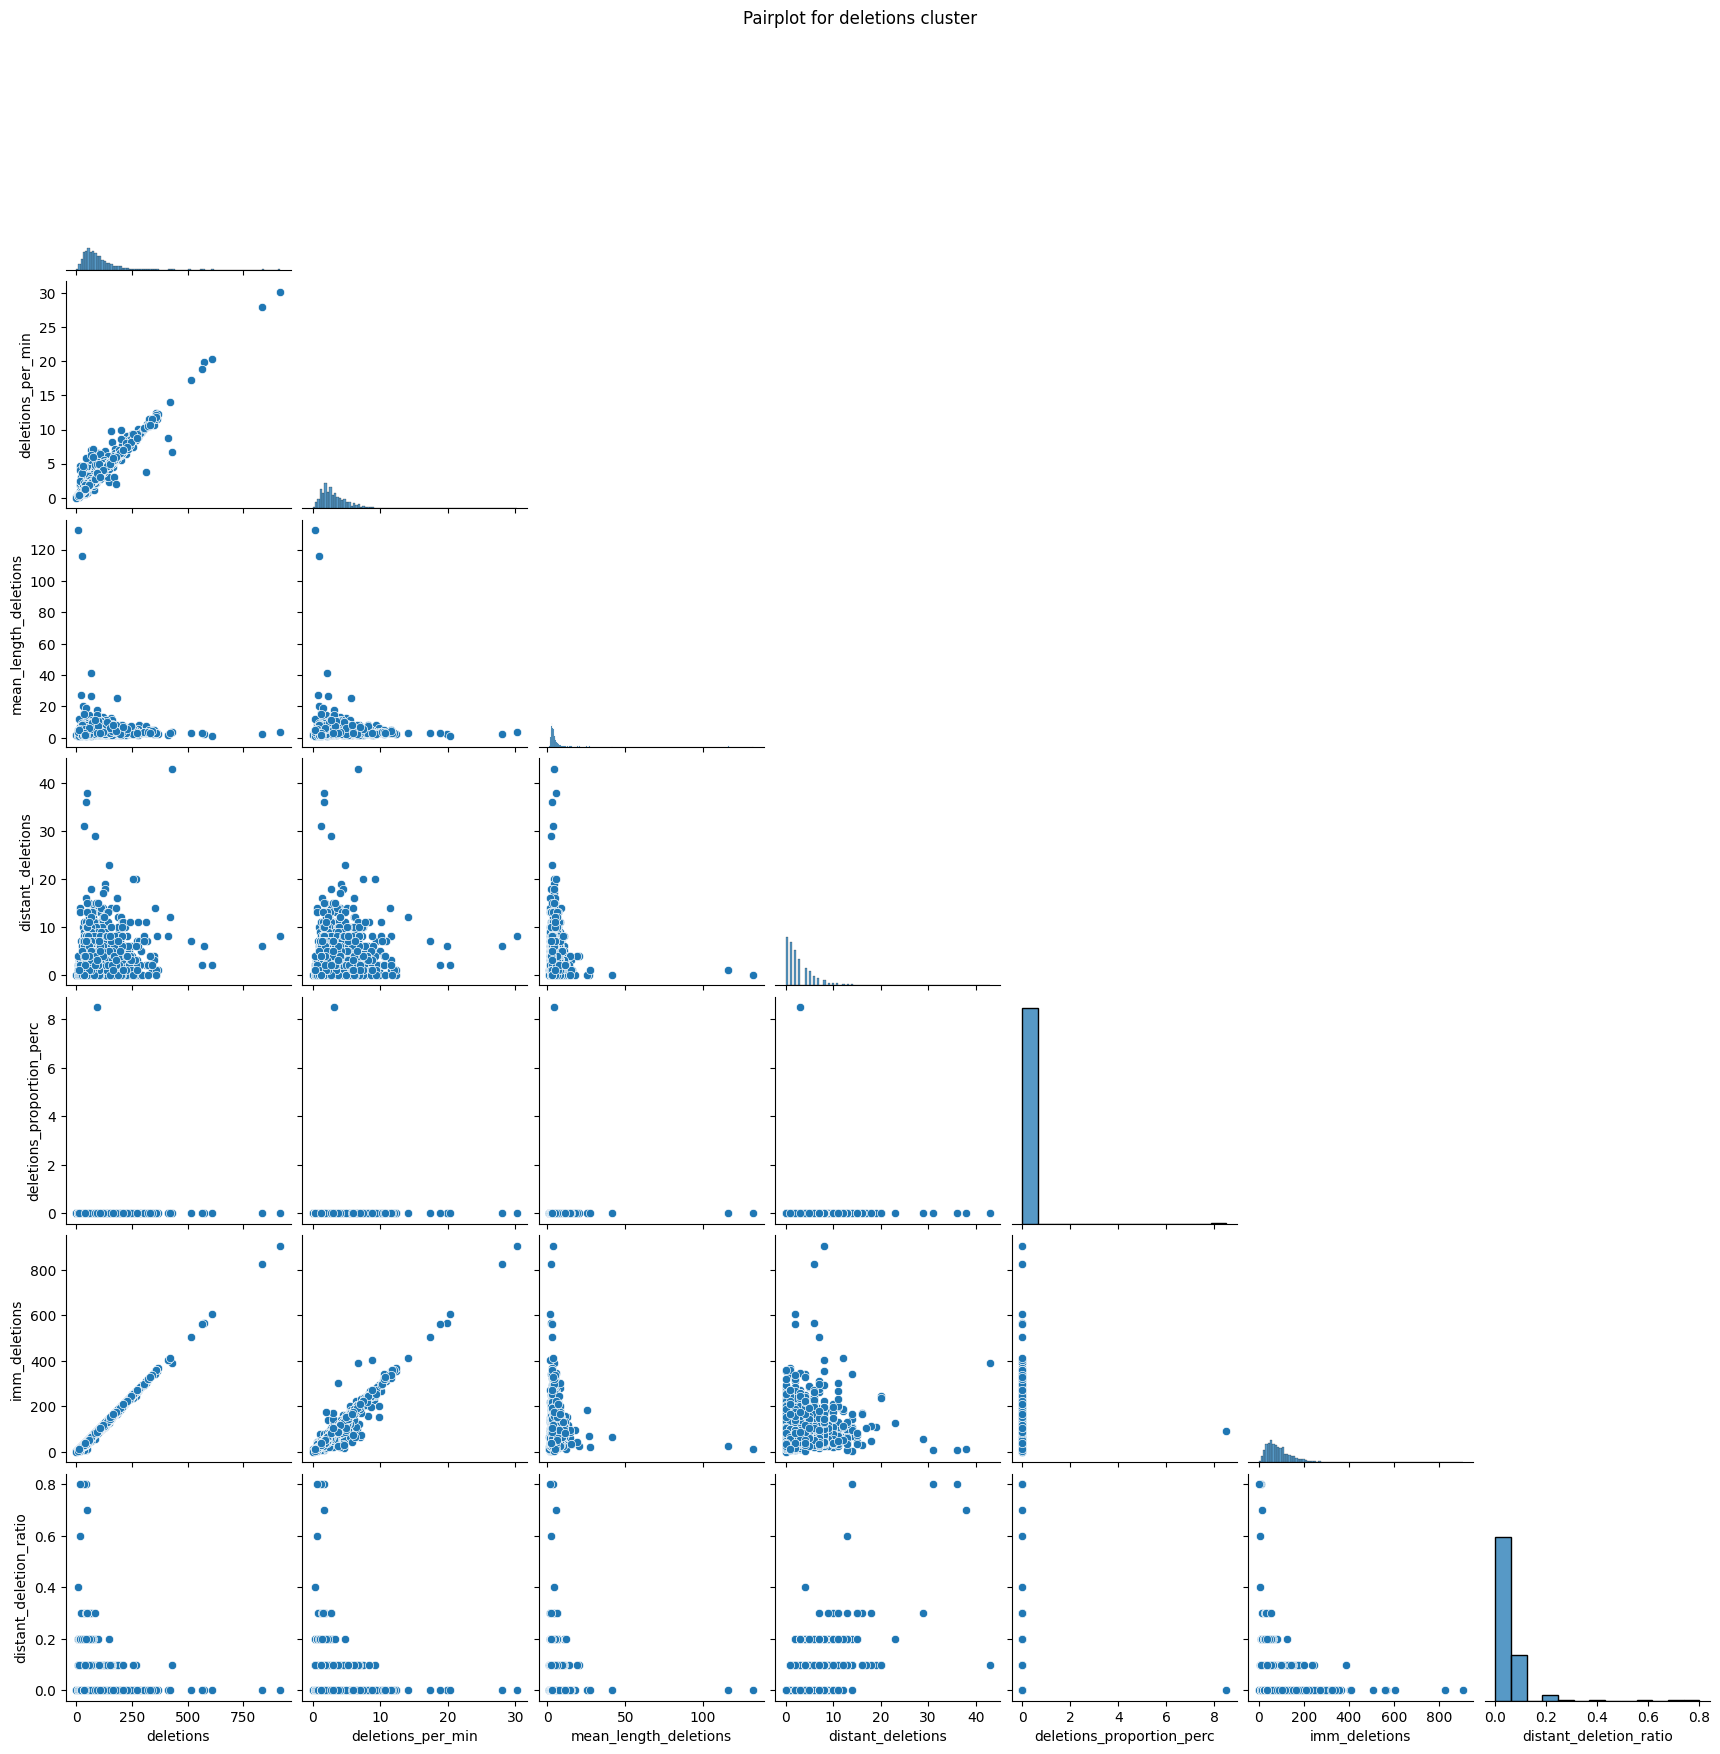

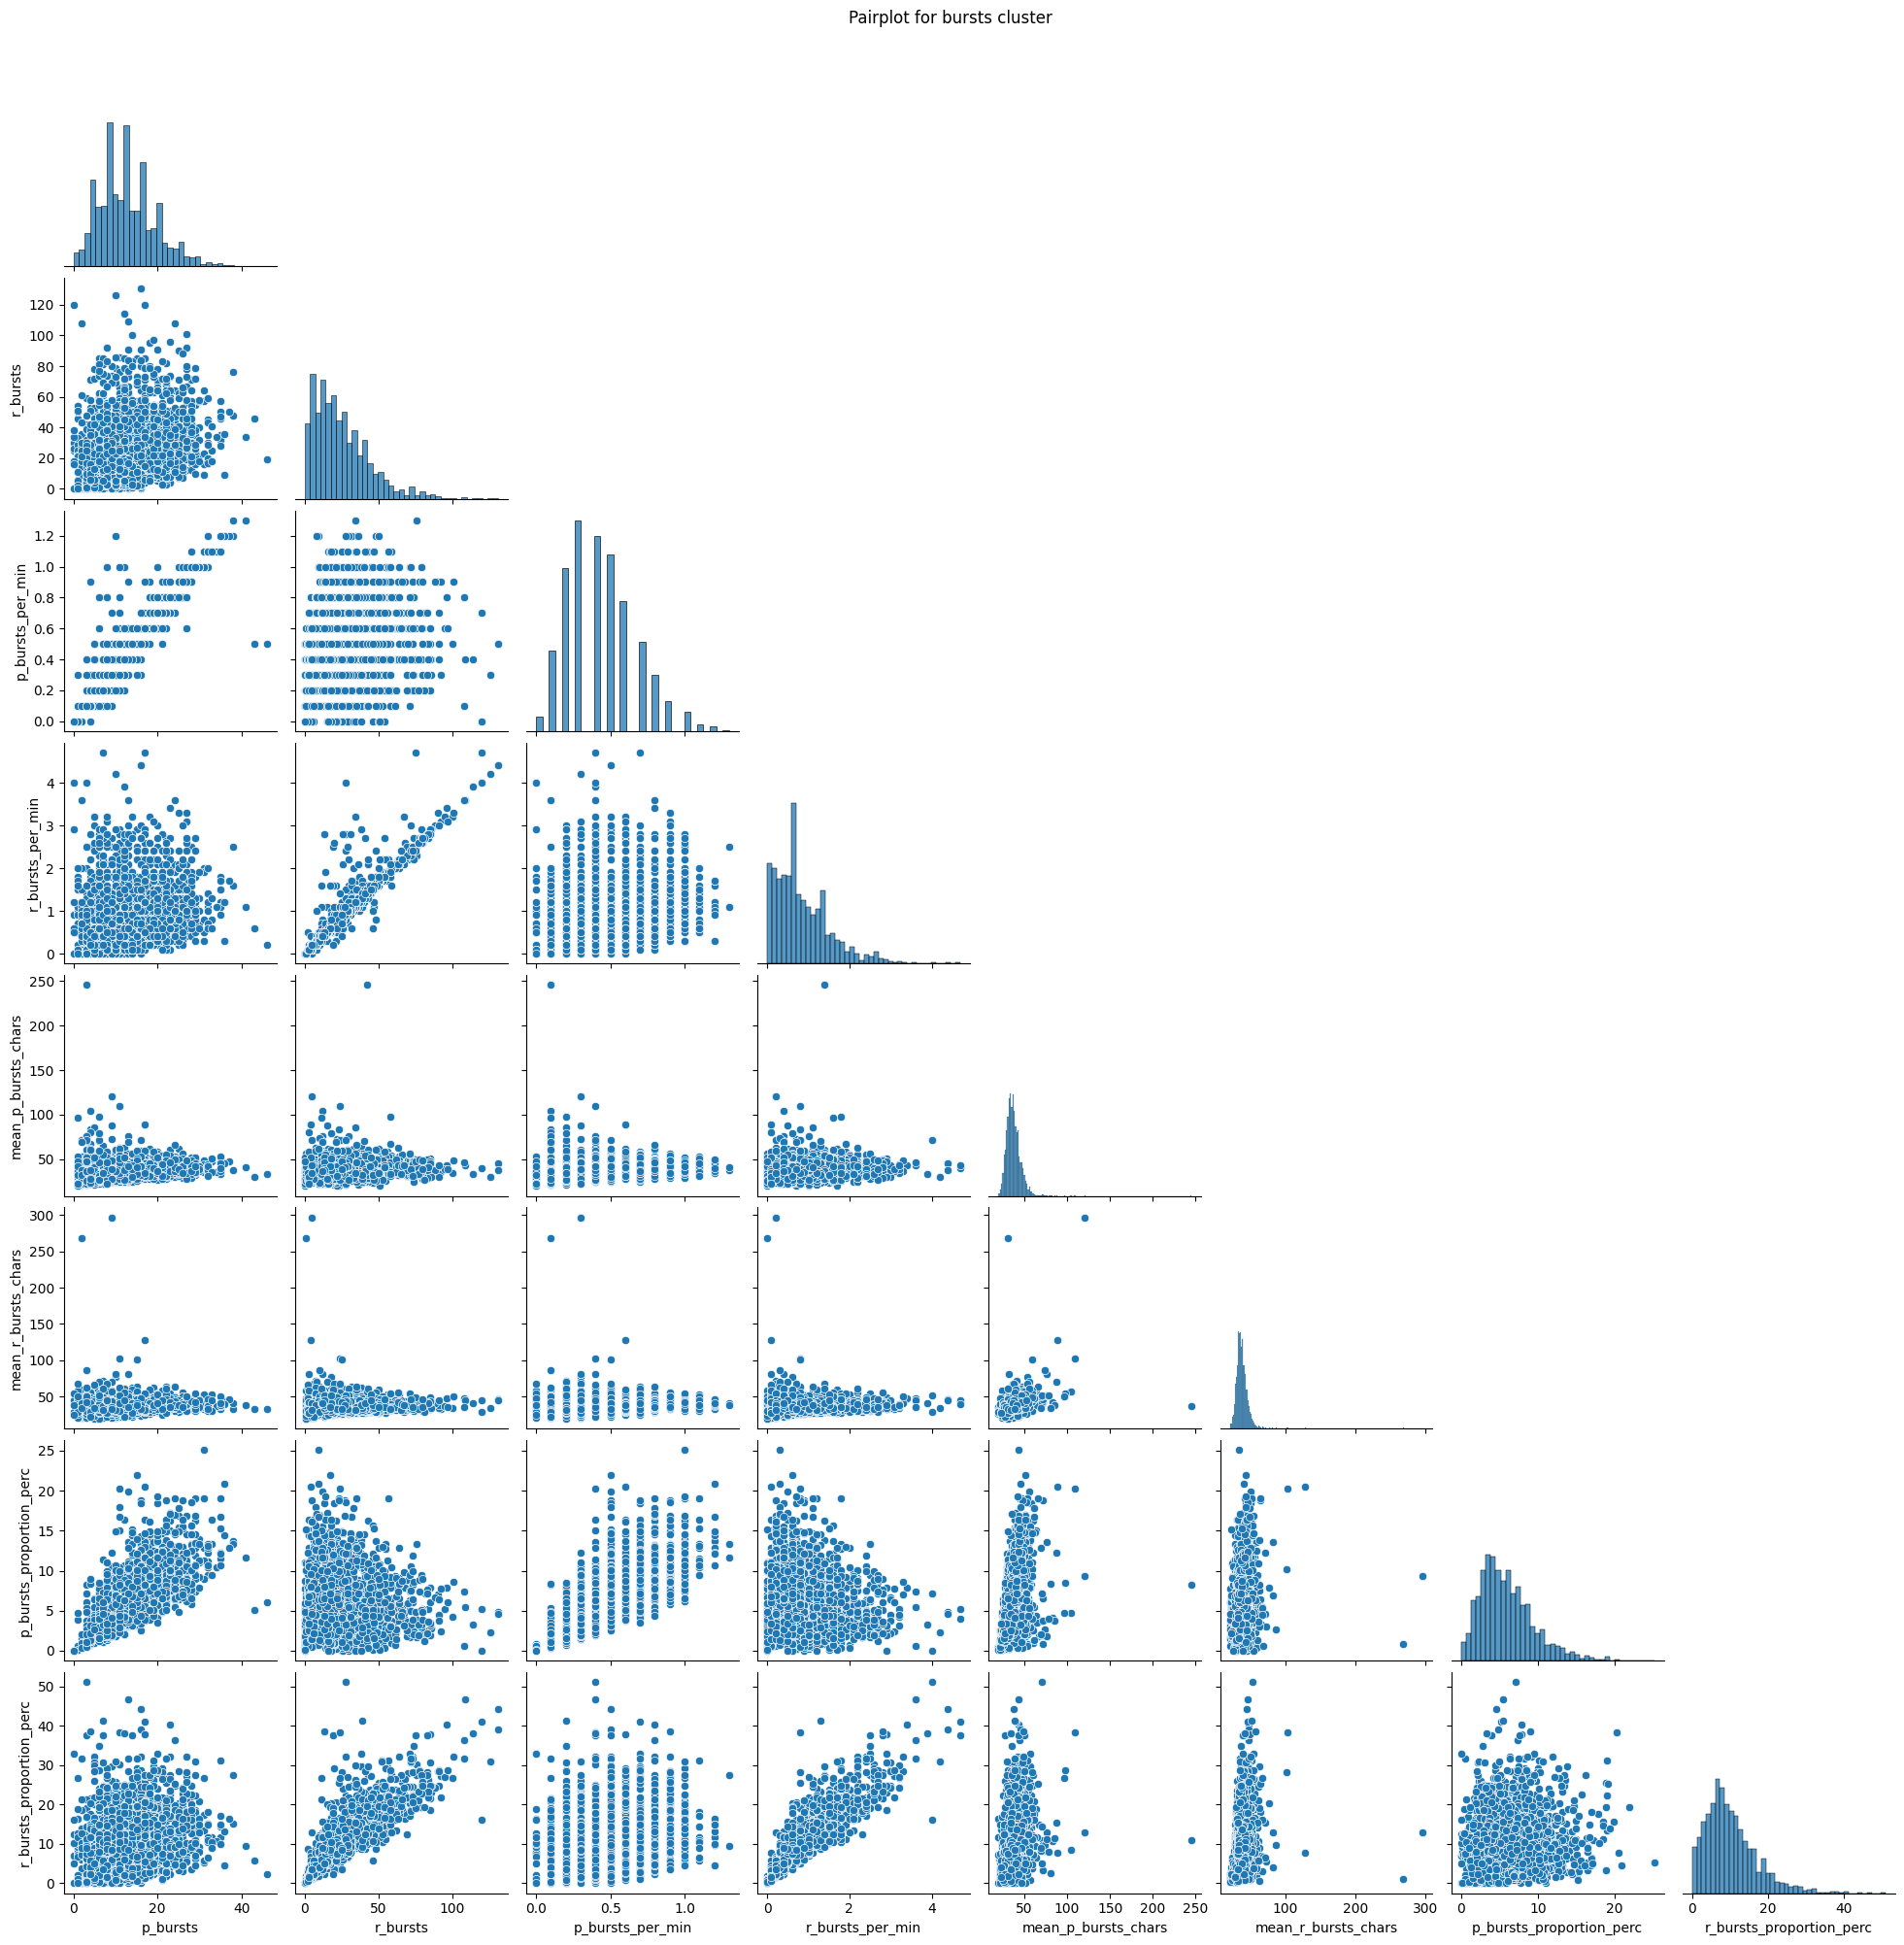

In [25]:
for i, feature_cluster in enumerate(feature_clusters):
    pair_plot = sns.pairplot(simplified_train_logs[feature_cluster], corner=True)
    pair_plot.fig.suptitle(f'Pairplot for {feature_clusters_str[i]}', y=1.005)

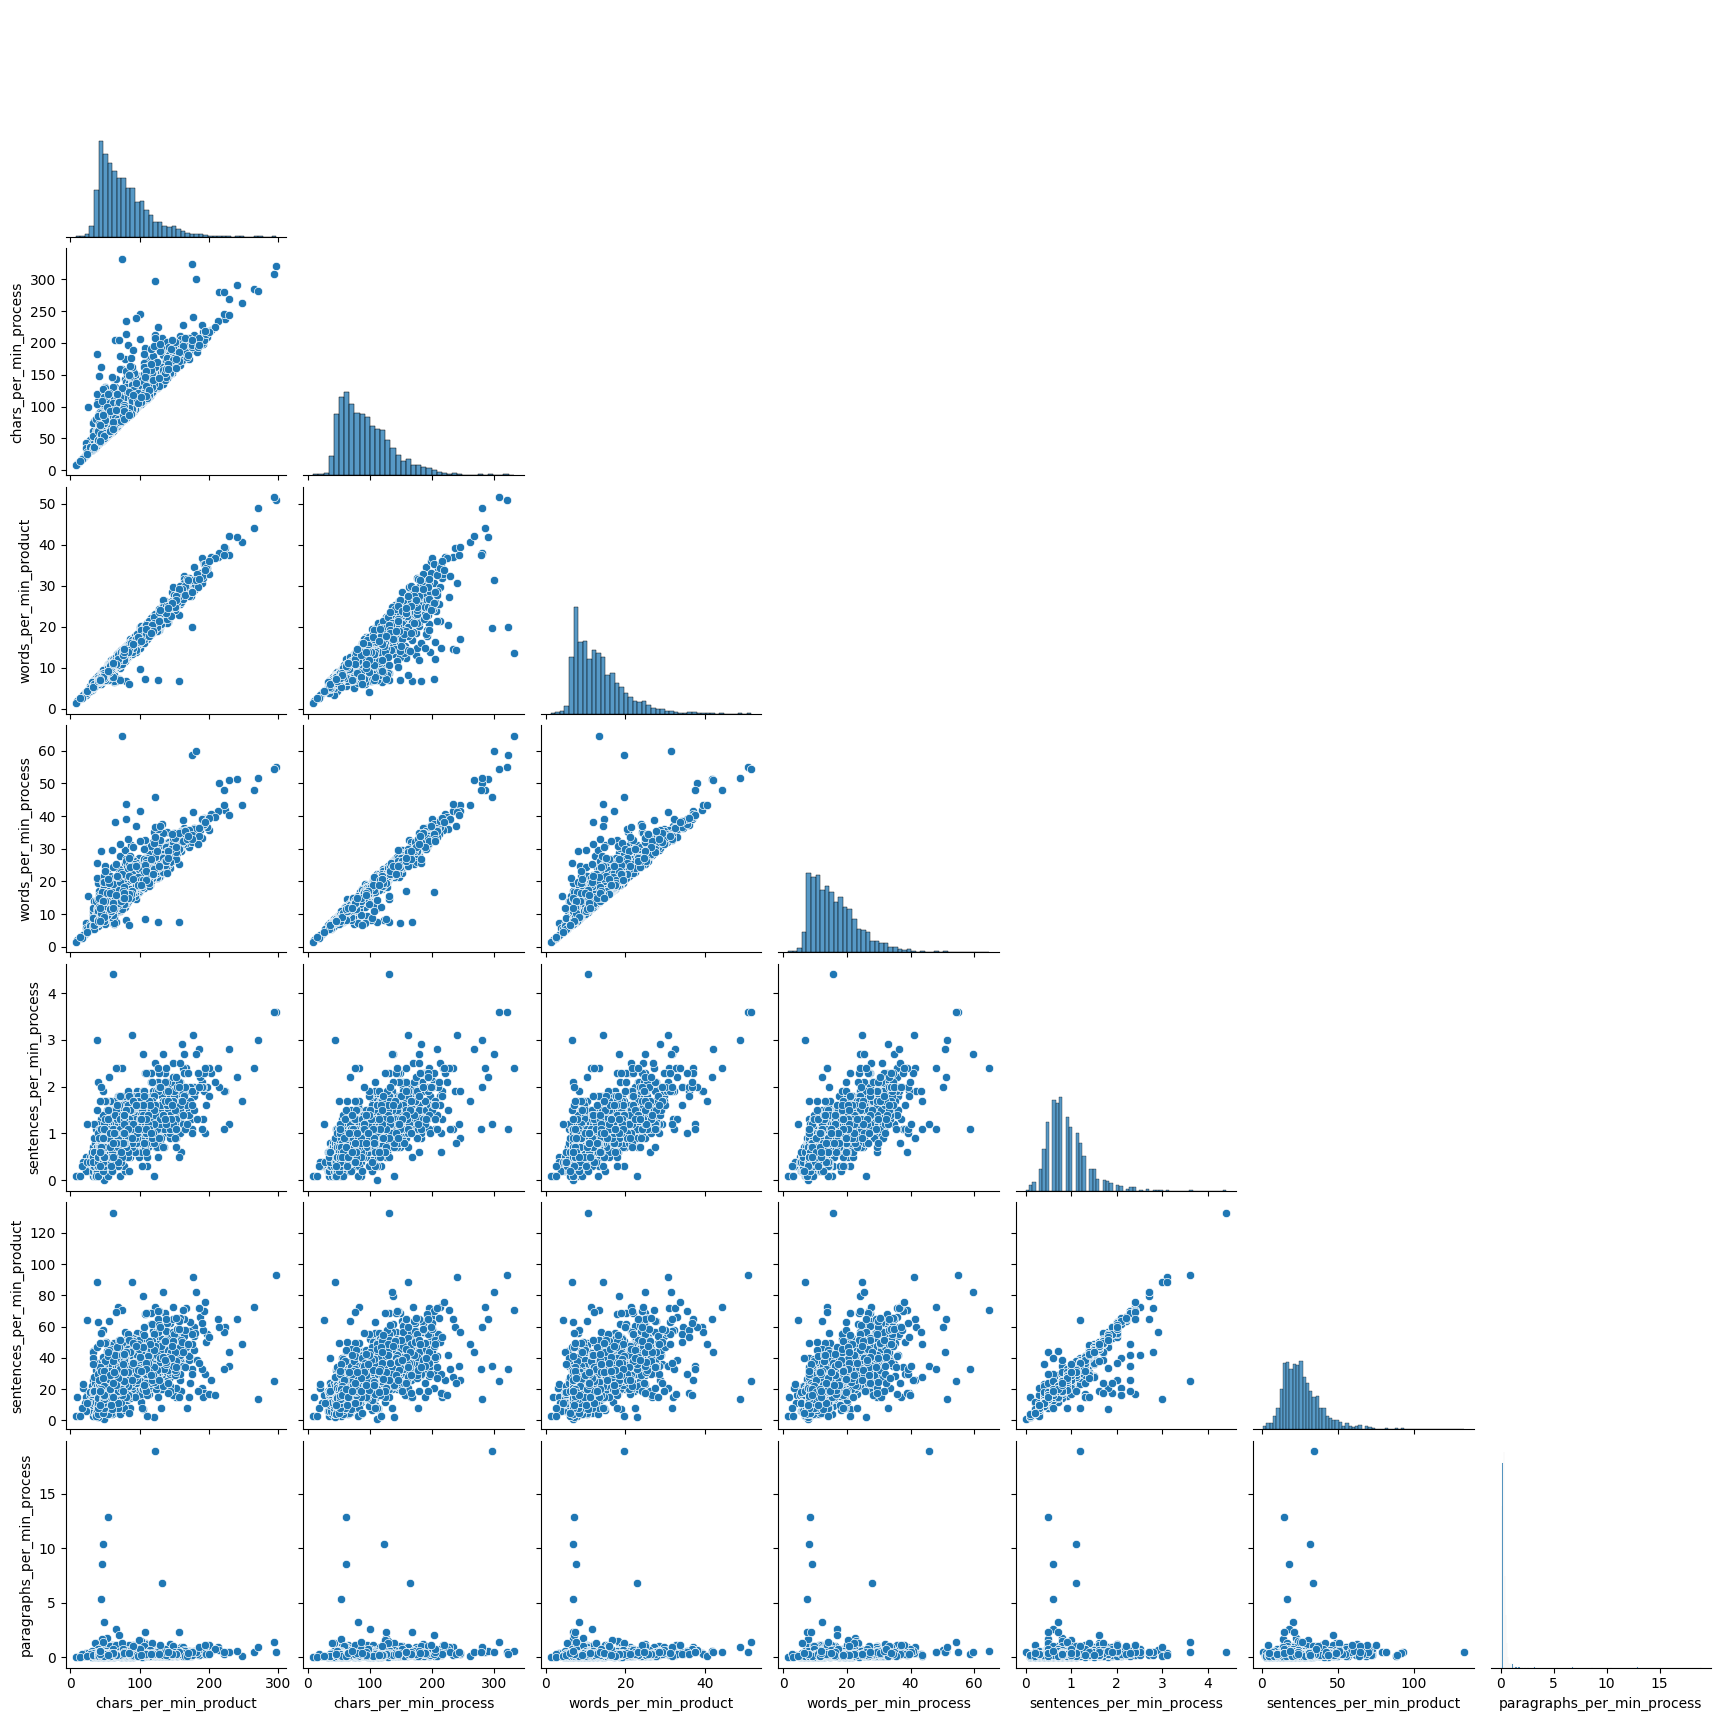

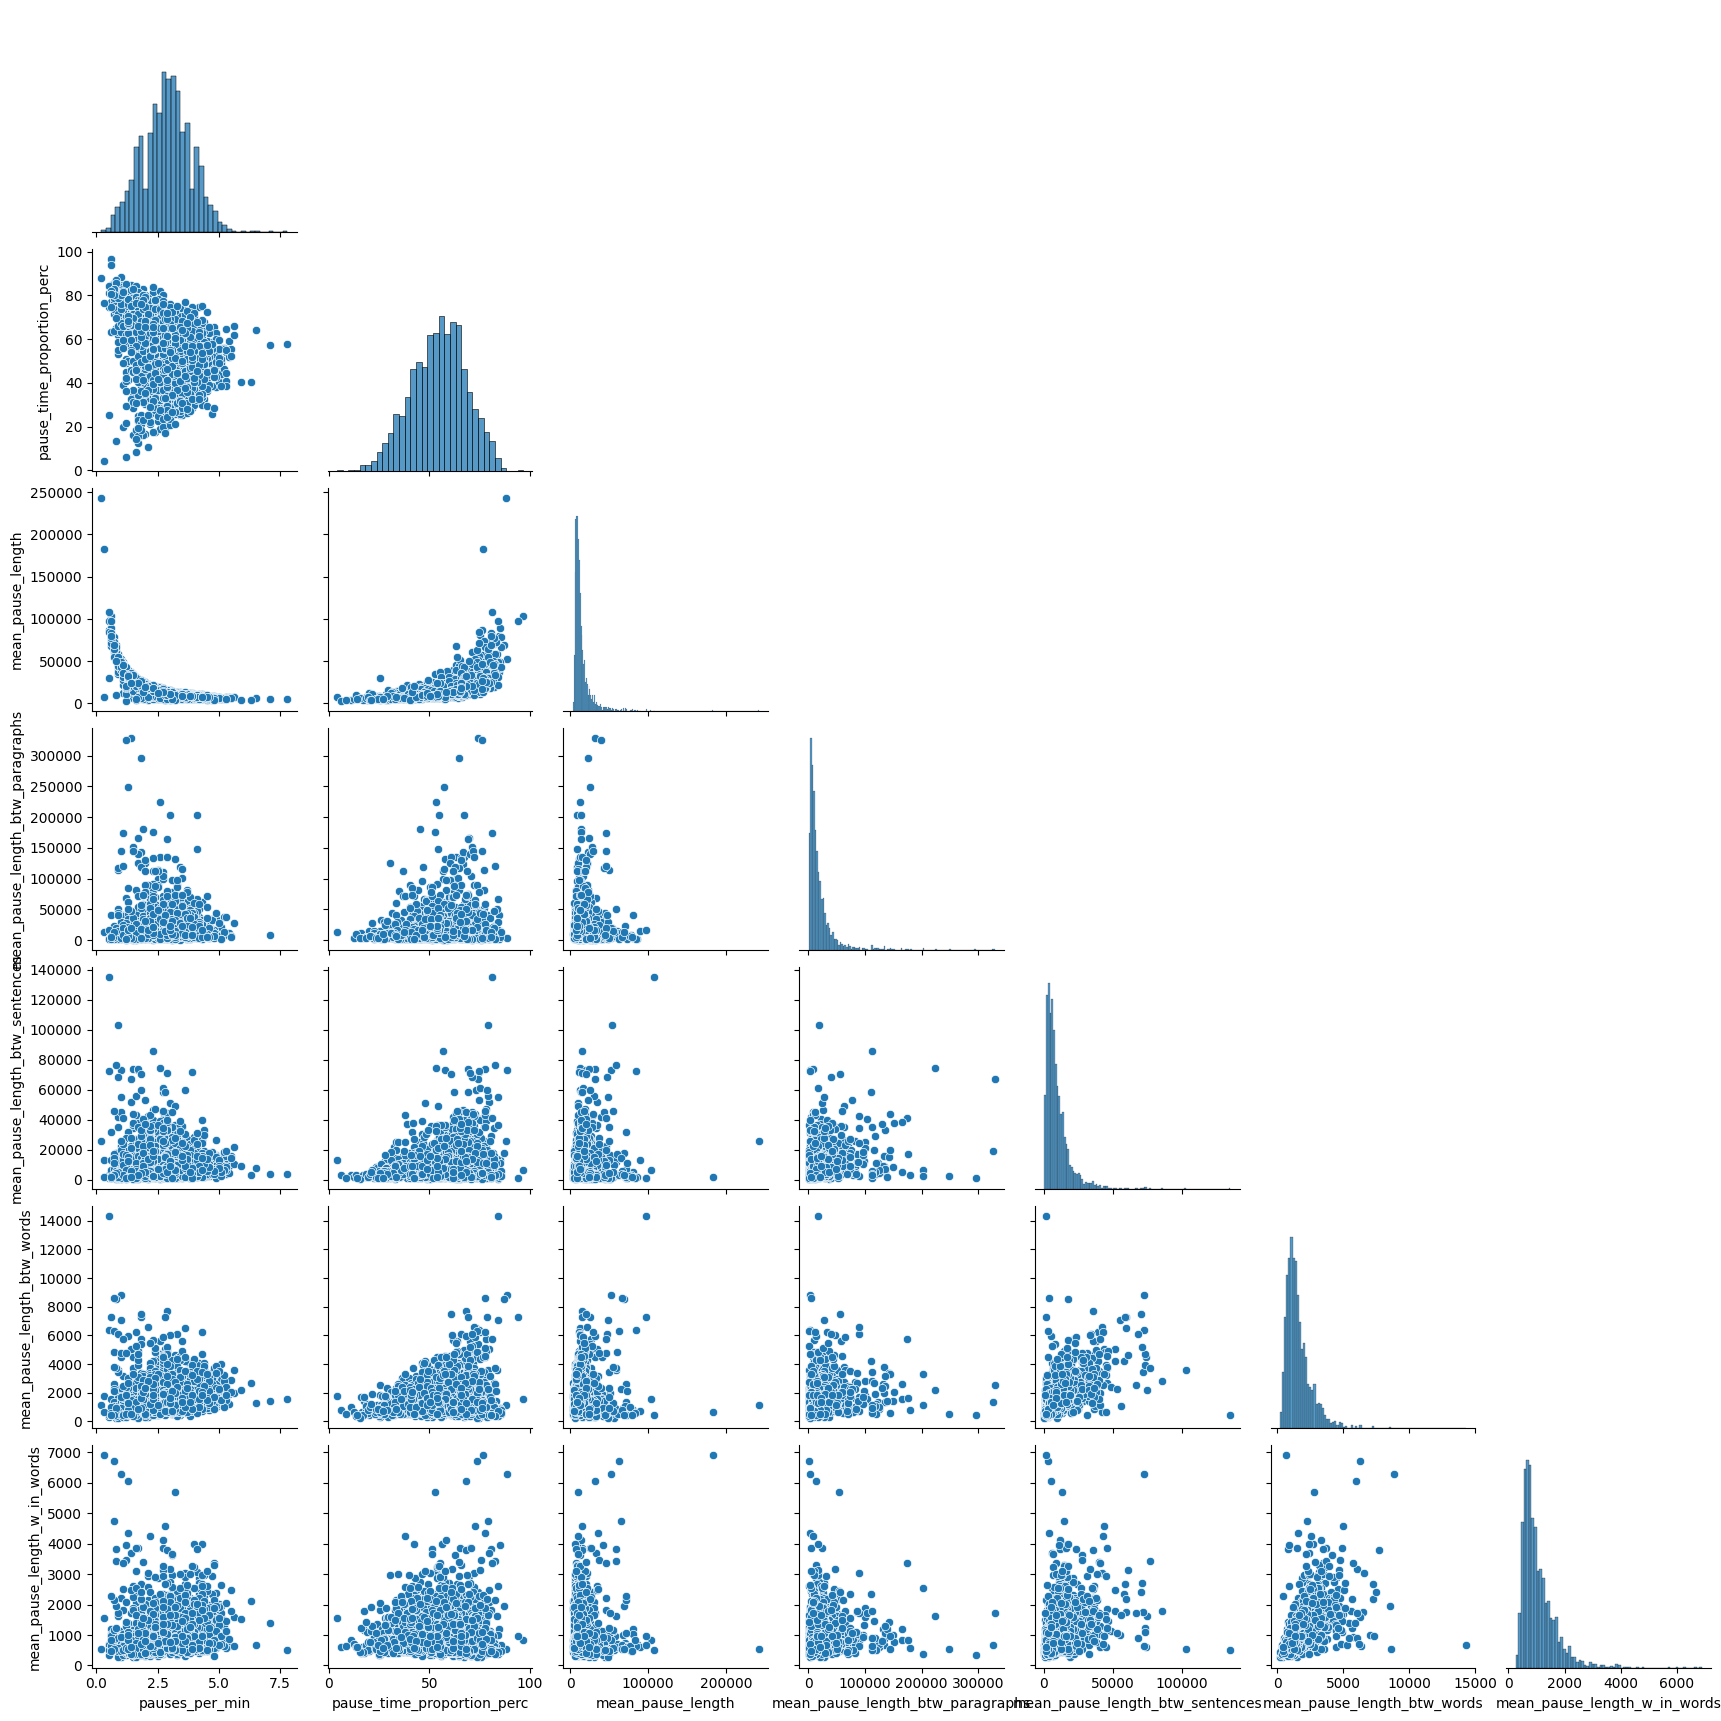

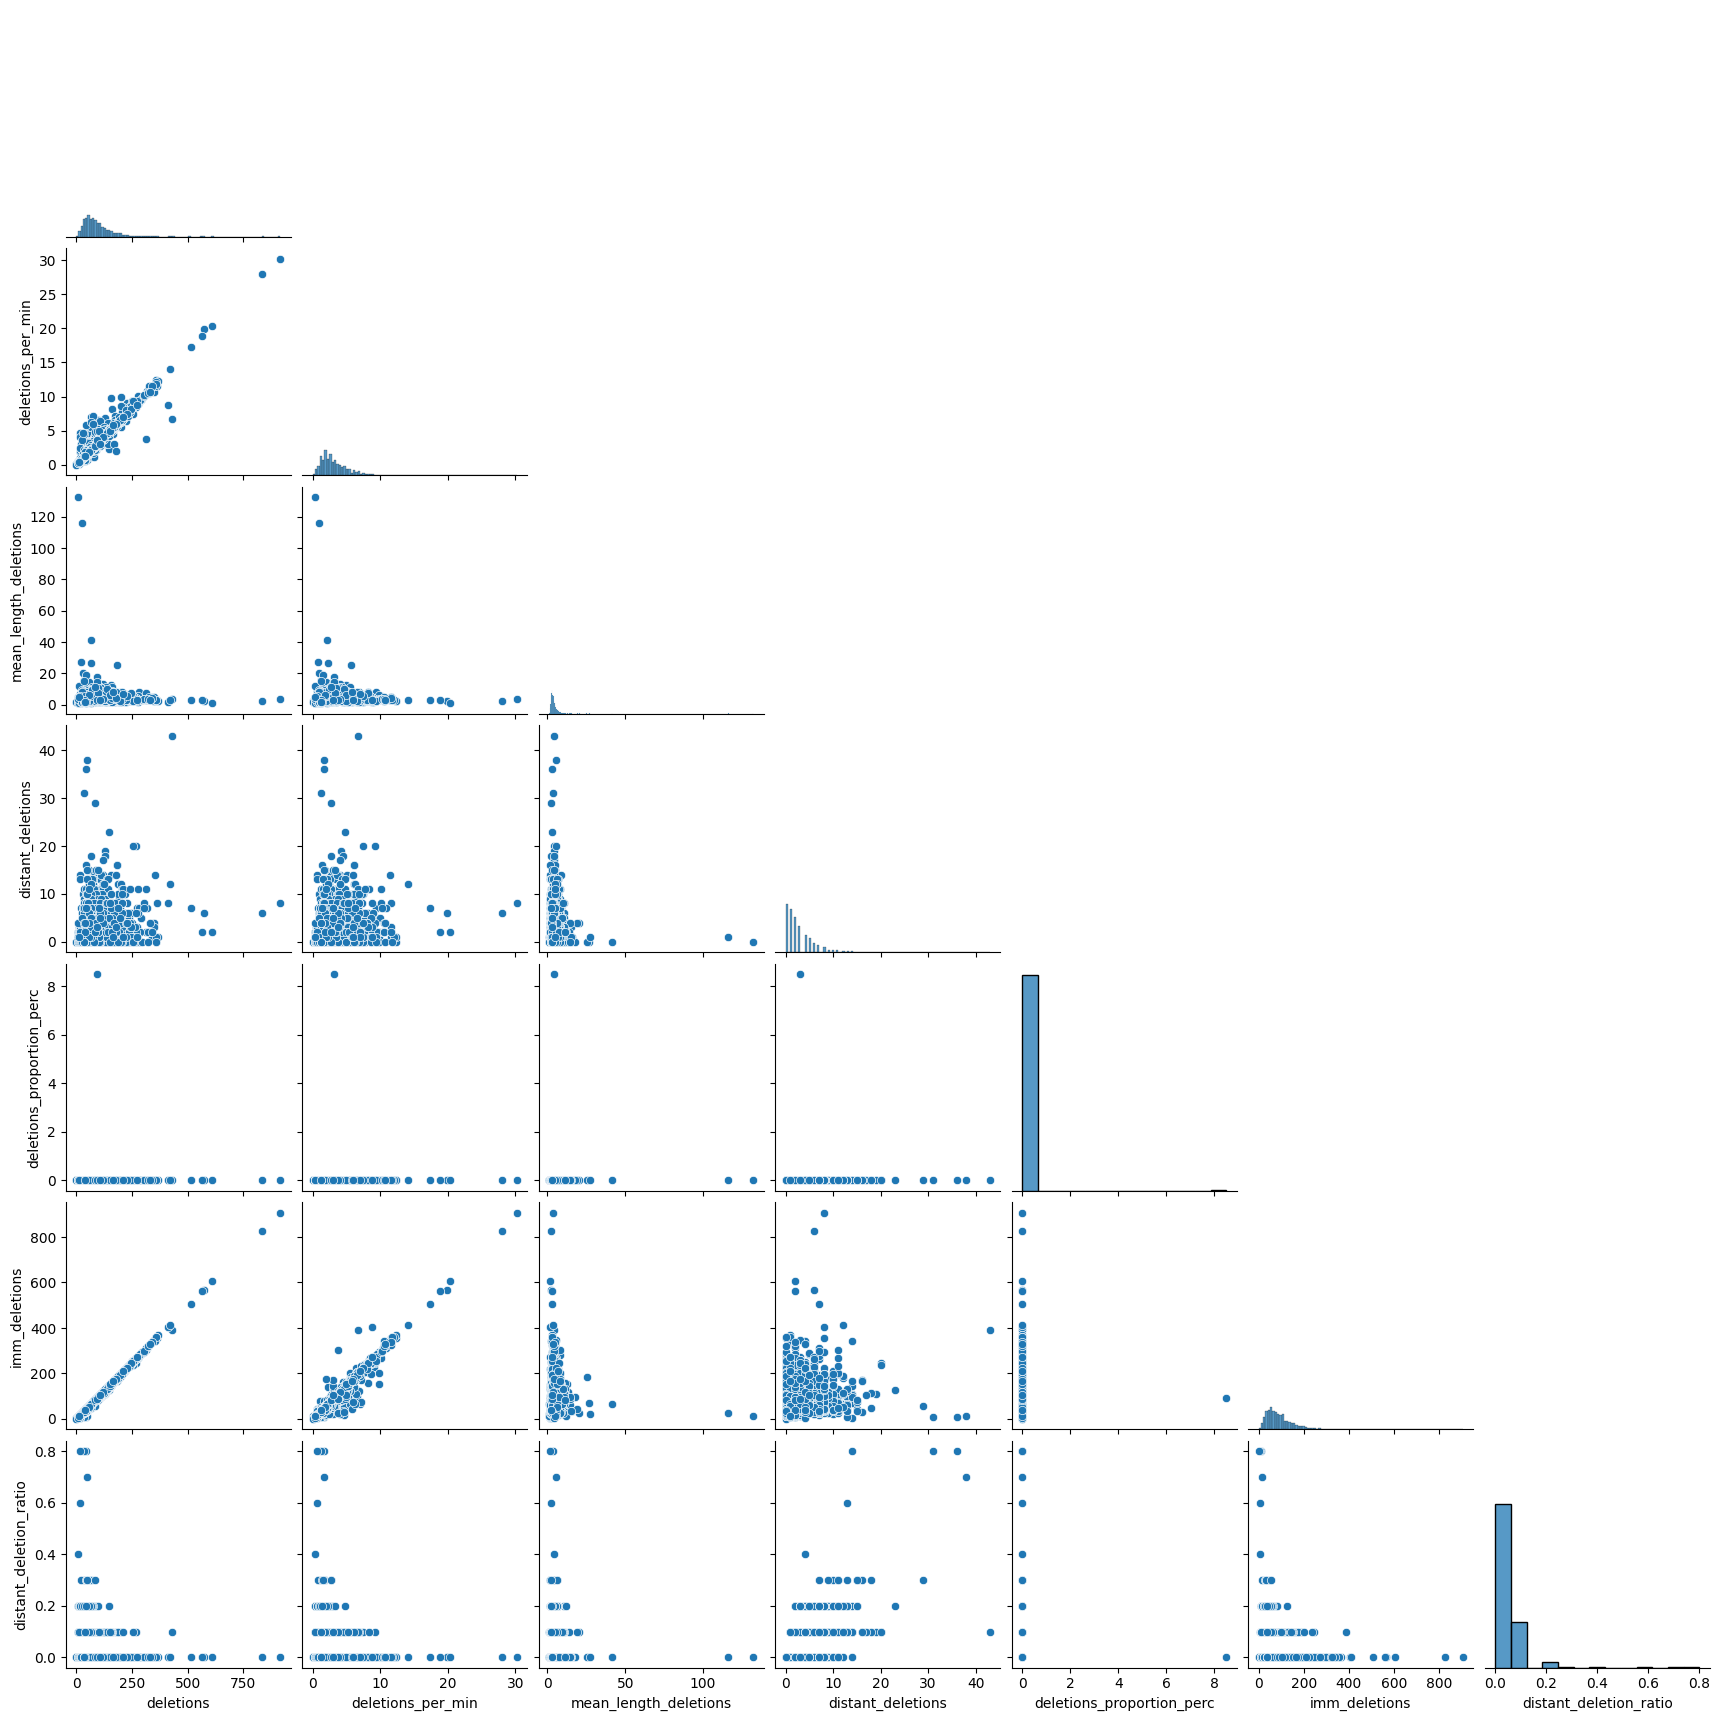

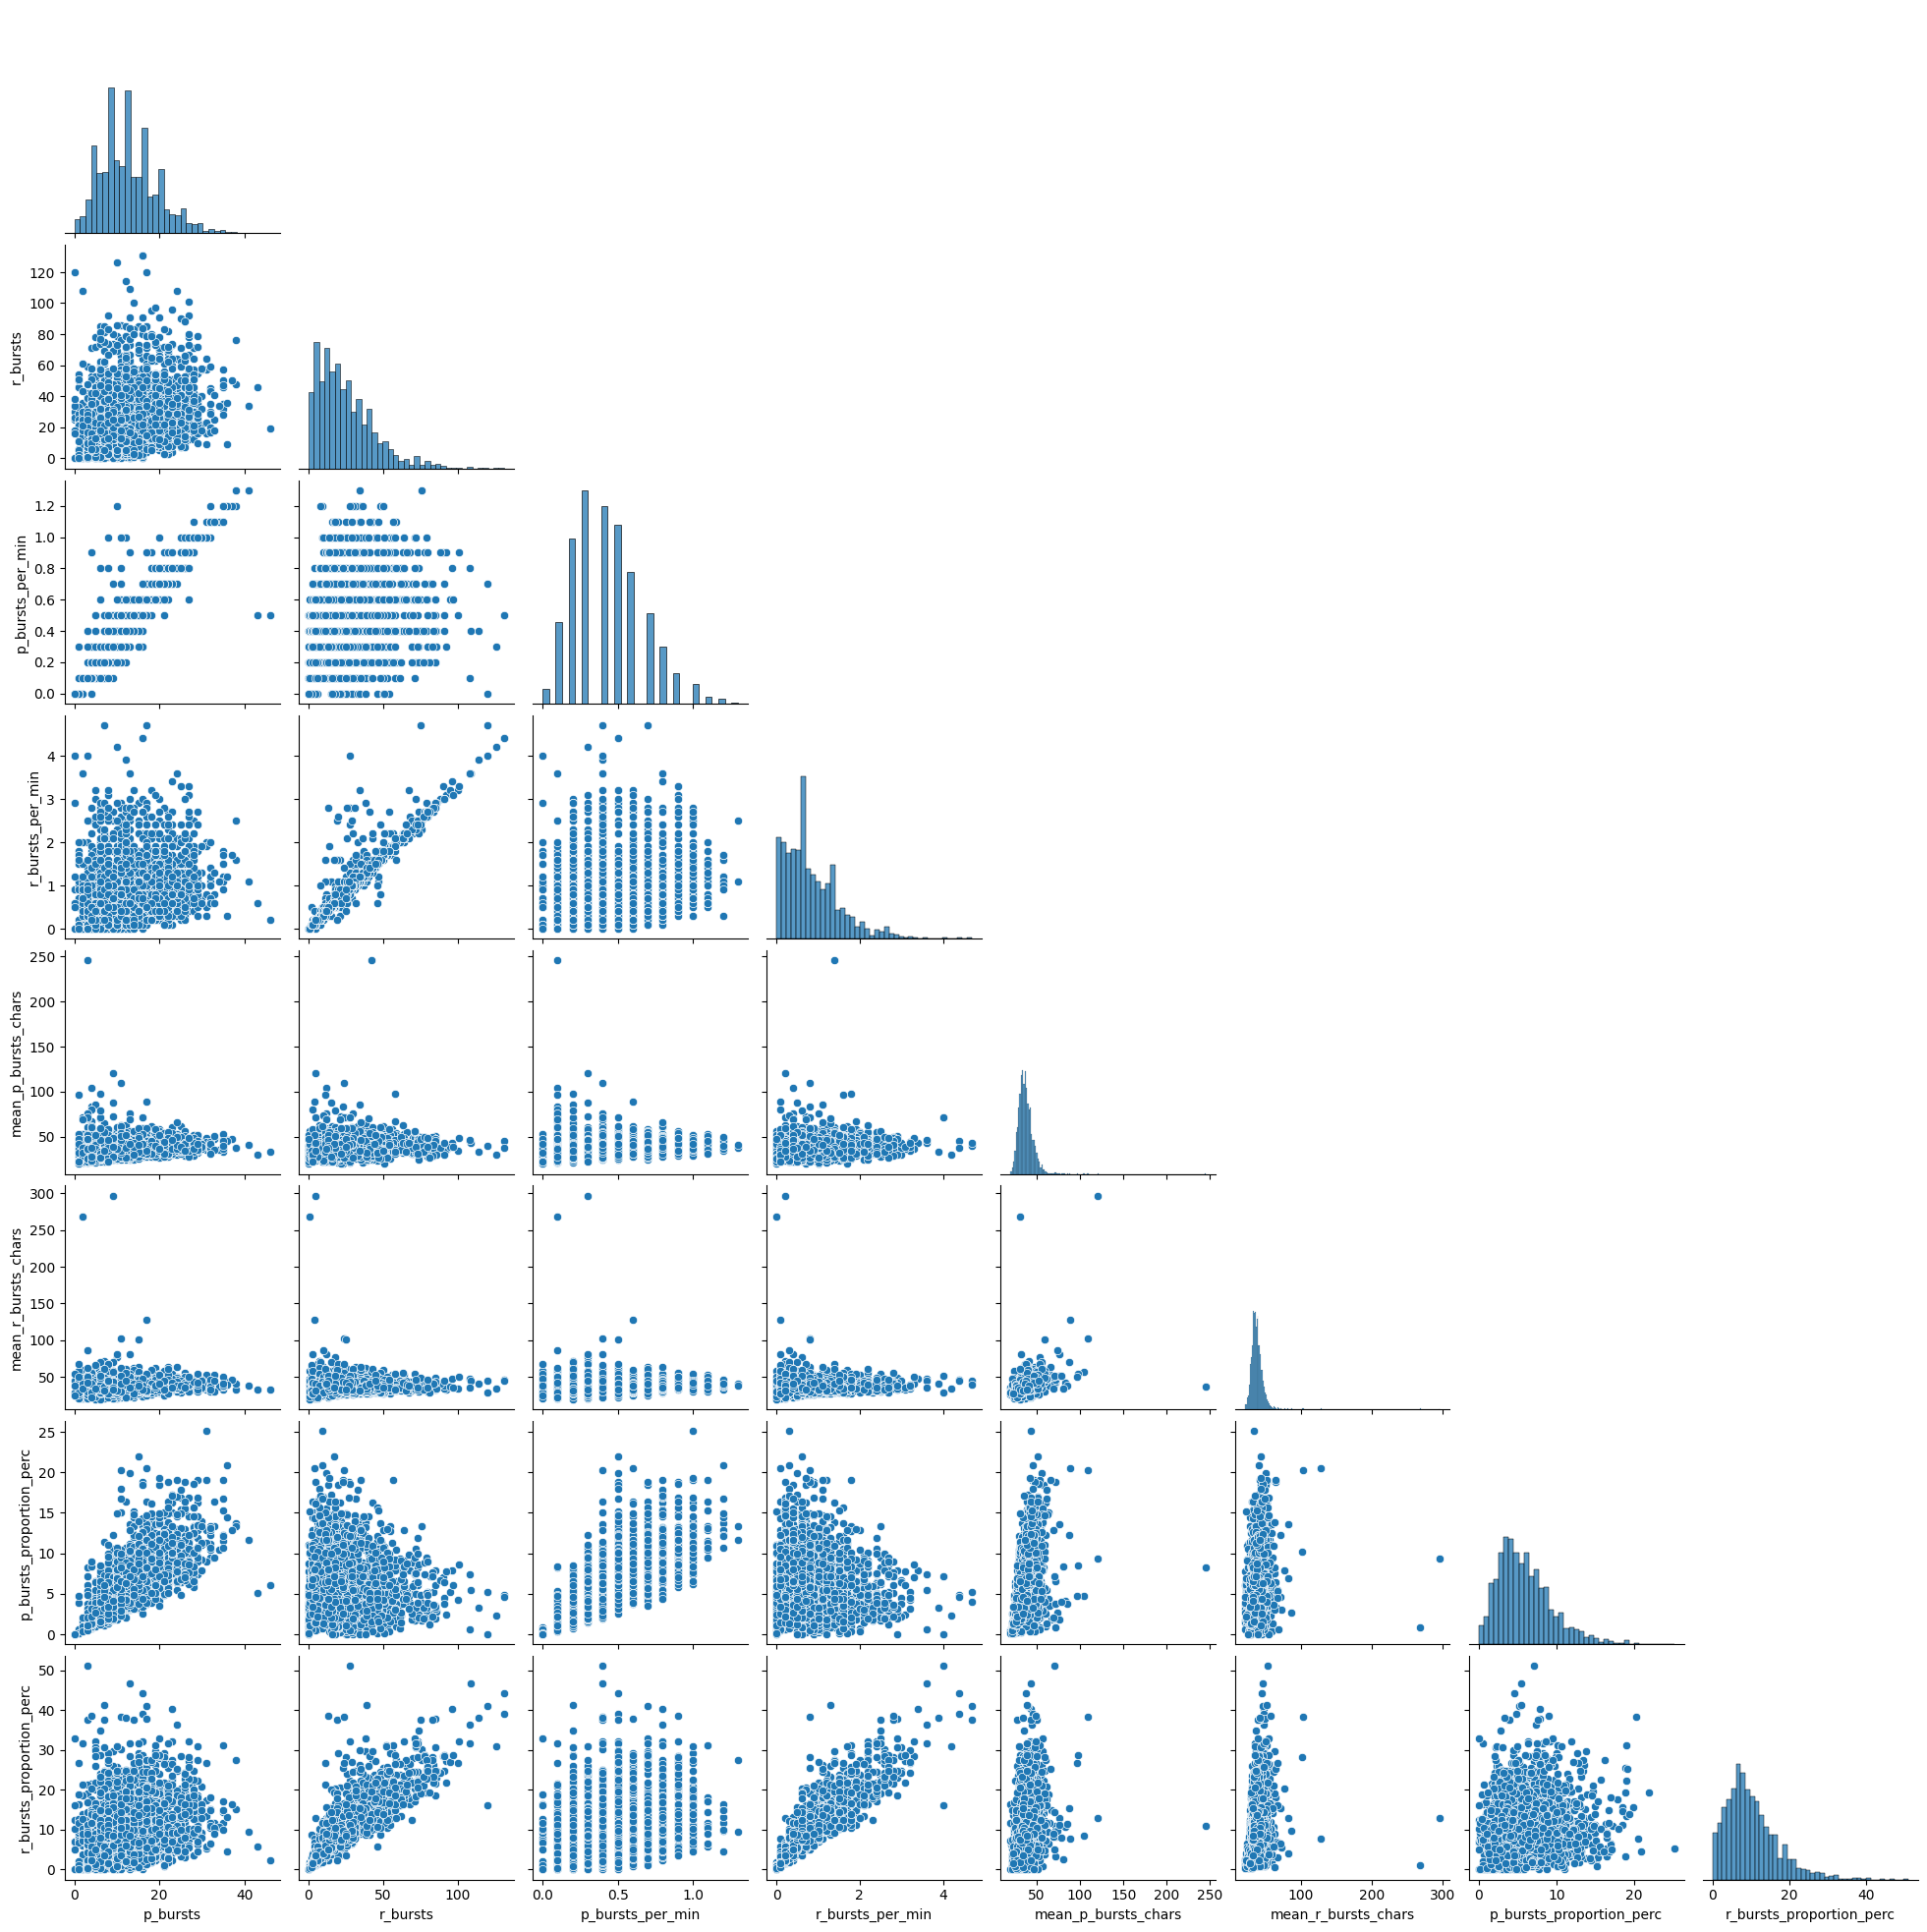

In [26]:
for feature_cluster in feature_clusters:
    sns.pairplot(simplified_train_logs[feature_cluster], corner=True)

In [27]:
highly_correl_cols = ['chars_per_min_product', 'words_per_min_process', 'imm_deletions', 
                      'deletions_per_min', 'r_bursts_per_min']
simplified_train_logs.drop(highly_correl_cols, axis=1, inplace=True)
len(simplified_train_logs.columns)

29

In [28]:
# split first?
from sklearn.cluster import KMeans
kmeans = KMeans().fit(simplified_train_logs.fillna(0))
simplified_train_logs['kmeans_clusters'] = kmeans.labels_
simplified_train_logs['kmeans_clusters'].value_counts()

kmeans_clusters
0    1332
2     544
7     235
5     142
3     139
6      40
4      32
1       7
Name: count, dtype: int64

In [29]:
# pca
from sklearn.decomposition import PCA
logs_pca = PCA(n_components = 4)
components = logs_pca.fit(simplified_train_logs.fillna(0)).components_
var_ratio = logs_pca.explained_variance_ratio_
var_ratio= pd.DataFrame(var_ratio).transpose()
var_ratio.columns = ['Comp1', 'Comp2', 'Comp3', 'Comp4']
var_ratio.index = ['Proportion of Variance']
print(var_ratio)
# Comp4 seems useless. The first 3 components will be enough
logs_pcomp = logs_pca.fit_transform(simplified_train_logs.fillna(0))
logs_pcomp = pd.DataFrame(logs_pcomp)
logs_pcomp = logs_pcomp.iloc[:,0:3]
logs_pcomp.columns = ['Comp1', 'Comp2', 'Comp3']
logs_pcomp.head()

                           Comp1     Comp2    Comp3     Comp4
Proportion of Variance  0.715422  0.177894  0.10545  0.000989


,Comp1,Comp2,Comp3
0,4434.607704,-5226.002488,-934.804710
1,-15643.767848,-903.924115,-5486.509383
2,-10851.654516,-1178.267290,-5744.396165
3,46141.486731,-6169.904445,1537.990880
4,22650.359717,-2656.007386,920.564424


In [30]:
# delete highly_correl_cols from feature_clusters
feature_clusters = [list(set(cluster) - set(highly_correl_cols)) for cluster in feature_clusters]
feature_clusters

[['chars_per_min_process',
  'paragraphs_per_min_process',
  'sentences_per_min_process',
  'sentences_per_min_product',
  'words_per_min_product'],
 ['pause_time_proportion_perc',
  'mean_pause_length_btw_sentences',
  'mean_pause_length',
  'mean_pause_length_btw_paragraphs',
  'mean_pause_length_w_in_words',
  'mean_pause_length_btw_words',
  'pauses_per_min'],
 ['deletions_proportion_perc',
  'distant_deletion_ratio',
  'mean_length_deletions',
  'distant_deletions',
  'deletions'],
 ['mean_p_bursts_chars',
  'p_bursts_proportion_perc',
  'mean_r_bursts_chars',
  'r_bursts_proportion_perc',
  'p_bursts_per_min',
  'p_bursts',
  'r_bursts']]